# 영화를 추천해보자


코로나가 심각해지면서 집에 있는 시간이 늘어나게되고 OTT 서비스들이 증가하였습니다.

자연스래 사람들에 니즈에 따라 볼거리를 추천해주는 추천시스템

또한 많이 발전하게 되었습니다.

오늘은 그중 영화를 추천해주는 프로젝트를 한번 해보겠습니다.

---

목차

데이터 준비와 전처리

csr_matrix 만들기

모델 만들기

모델 학습 및 결과 확인

피어슨 상관계수를 사용한 간단한 추천시스템

마무리

---

## 데이터 준비와 전처리

### 필요한 라이브러리 임포트

In [63]:
import numpy as np
import pandas as pd
import os
import scipy
import implicit
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

---

### 데이터 불러오기
- 첫번째로 불러올 데이터는 ratings라는 영화 평점 데이터입니다.
- 컬럼은 'user_id', 'movie_id', 'rating', 'timestamp'만 불러오겠습니다.

In [64]:
rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
# 보여줄 컬럼 정의
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python')
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


---

### rating 점수에 따른 분포 확인
- rating 점수에 따른 분포를 확인해보고 필요 없는 것은 삭제
- 데이터 용량을 줄이기 위함

In [65]:
ratings['rating'].value_counts()

4    348971
3    261197
5    226310
2    107557
1     56174
Name: rating, dtype: int64

---

### 시각화로 확인해보기

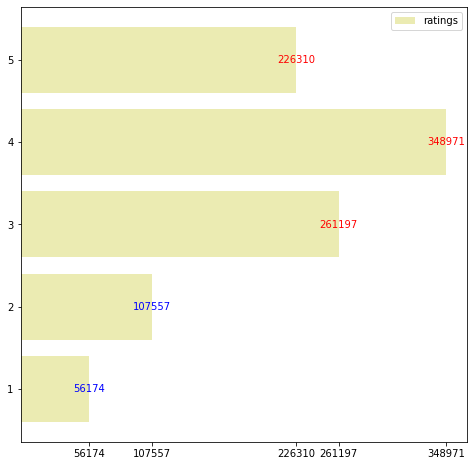

In [66]:
ratings_users = ratings.groupby(by=['rating']).agg({'user_id': 'count'}).reset_index()
ratings_users.columns = ['ratings', 'users']
ratings_users_dic = {ratings:users for ratings, users in zip(ratings_users.ratings, ratings_users.users)}

plt.figure(figsize=(8,8))
plt.barh(ratings_users.ratings, ratings_users.users, align='center', alpha=0.3, color='y')
plt.yticks(ratings_users.ratings)
plt.xticks(ratings_users.users)
plt.legend(ratings_users.columns)

for i, users in enumerate(ratings_users.users):
    if i >= 2:
        color = 'r'
    else:
        color = 'b'
    plt.text(users+i,1+i,users, horizontalalignment='center', verticalalignment='center', color=color)

plt.show()

---

### 데이터 전처리(1)
- 3점 미만은 데이터가 적고 볼 필요가 없다고 판단하고 데이터를 삭제함
- rating 컬럼명을 count로 변경

In [67]:
# 3점 이상만 모아두겠다
ratings = ratings[ratings['rating']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [68]:
# ratings 컬럼의 이름을 counts로 바꿉니다.
ratings.rename(columns={'rating':'count'}, inplace=True)
ratings

,user_id,movie_id,count,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000203,6040,1090,3,956715518
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


---

### movie_data load

위의 데이터는 영화 평점이 담겨있는 평점 데이터셋입니다.

물론 movie_id라는 항목이 존재하지만, 영화명이 따로 존재하지는 않습니다.

그래서 movie라는 데이터를 따로 로드하여 movie_id에 매칭되는 영화이름을 알아보겠습니다.

In [69]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


---

### 데이터 전처리(2)
- 영화 이름에서 날짜를 지움
- 이름을 전부 소문자로 바꿈

In [70]:
import re

pattern = re.compile('[^a-zA-Z]*$')
movies['title'] = movies['title'].map(lambda x : pattern.sub('', x))
movies['title'] = movies['title'].str.lower()

movies.head()

,movie_id,title,genre
0,1,toy story,Animation|Children's|Comedy
1,2,jumanji,Adventure|Children's|Fantasy
2,3,grumpier old men,Comedy|Romance
3,4,waiting to exhale,Comedy|Drama
4,5,father of the bride part ii,Comedy


---

### 데이터 전처리(3)
- ratings에 있는 유니크한 영화 개수 확인
- ratings에 있는 유니크한 사용자 수 확인
- 가장 인기 있는 영화 30개 뽑아보기

In [71]:
print(ratings['movie_id'].nunique())
print(ratings['user_id'].nunique())

3628
6039


In [72]:
good_movie = ratings['movie_id'].value_counts()[:30]

#영화 이름은 물론이고, 몇명이 봤는지도 출력
for i, k in zip(good_movie.index, good_movie.values):
    print(movies[movies['movie_id']==i]['title'].values[0],':',k)

american beauty : 3211
star wars: episode iv - a new hope : 2910
star wars: episode v - the empire strikes back : 2885
star wars: episode vi - return of the jedi : 2716
saving private ryan : 2561
terminator 2: judgment day : 2509
silence of the lambs, the : 2498
raiders of the lost ark : 2473
back to the future : 2460
matrix, the : 2434
jurassic park : 2413
sixth sense, the : 2385
fargo : 2371
braveheart : 2314
men in black : 2297
schindler's list : 2257
princess bride, the : 2252
shakespeare in love : 2213
l.a. confidential : 2210
shawshank redemption, the : 2194
godfather, the : 2167
groundhog day : 2121
e.t. the extra-terrestrial : 2102
being john malkovich : 2066
ghostbusters : 2051
pulp fiction : 2030
forrest gump : 2022
terminator, the : 2019
toy story : 2000
fugitive, the : 1941


---

### 값 확인해보기

In [22]:
user_count = ratings.groupby('user_id')['movie_id'].count()
user_count.describe()

count    6039.000000
mean      138.512668
std       156.241599
min         1.000000
25%        38.000000
50%        81.000000
75%       177.000000
max      1968.000000
Name: movie_id, dtype: float64

In [23]:
user_median = ratings.groupby('user_id')['count'].median()
user_median.describe()

count    6039.000000
mean        4.055970
std         0.432143
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: count, dtype: float64

---

### 데이터 전처리(4)

영화명이 나와있는 movie 데이터와 평점이 나와있는 ratings 데이터를

보기 편하게 합쳐 주겠습니다.

두 데이터셋에서 movie_id가 중복되므로 movie_id를 기준으로 합치겠습니다.

In [24]:
ratings_title = pd.merge(ratings, movies[['title', 'movie_id']], on='movie_id', how='left')
ratings_title

,user_id,movie_id,count,timestamp,title
0,1,1193,5,978300760,one flew over the cuckoo's nest
1,1,661,3,978302109,james and the giant peach
2,1,914,3,978301968,my fair lady
3,1,3408,4,978300275,erin brockovich
4,1,2355,5,978824291,"bug's life, a"
...,...,...,...,...,...
836473,6040,1090,3,956715518,platoon
836474,6040,1094,5,956704887,"crying game, the"
836475,6040,562,5,956704746,welcome to the dollhouse
836476,6040,1096,4,956715648,sophie's choice


제 이름으로 영화 데이터를 추가해보겠습니다.

5개 정도만 추가해서 확인해보겠습니다.

In [27]:
my_favorite = ['toy story' , 'jumanji' ,'grumpier old men' ,'waiting to exhale' ,'father of the bride part ii']
my_favorite= list(map(lambda x : x.lower(), my_favorite))
my_favorite

my_playlist = pd.DataFrame({'user_id':['howon']*5, 'title':my_favorite, 'count':[5]*5})

if not ratings_title.isin({'user_id':['howon']})['user_id'].any():
    ratings_title = ratings_title.append(my_playlist)
    
ratings_title.tail(10)

,user_id,movie_id,count,timestamp,title
836473,6040,1090.0,3,956715518.0,platoon
836474,6040,1094.0,5,956704887.0,"crying game, the"
836475,6040,562.0,5,956704746.0,welcome to the dollhouse
836476,6040,1096.0,4,956715648.0,sophie's choice
836477,6040,1097.0,4,956715569.0,e.t. the extra-terrestrial
0,howon,NaN,5,NaN,toy story
1,howon,NaN,5,NaN,jumanji
2,howon,NaN,5,NaN,grumpier old men
3,howon,NaN,5,NaN,waiting to exhale
4,howon,NaN,5,NaN,father of the bride part ii


timestamp이라는 컬럼은 딱히 중요해보이지는 않아서 삭제하겠습니다.

In [28]:
ratings_title.reset_index(drop=True, inplace=True)
ratings_title.drop('timestamp', axis = 1, inplace=True)
ratings_title.tail(10)

,user_id,movie_id,count,title
836473,6040,1090.0,3,platoon
836474,6040,1094.0,5,"crying game, the"
836475,6040,562.0,5,welcome to the dollhouse
836476,6040,1096.0,4,sophie's choice
836477,6040,1097.0,4,e.t. the extra-terrestrial
836478,howon,NaN,5,toy story
836479,howon,NaN,5,jumanji
836480,howon,NaN,5,grumpier old men
836481,howon,NaN,5,waiting to exhale
836482,howon,NaN,5,father of the bride part ii


---

### 데이터 전처리(5)

이제 거의 막바지에 다왔습니다.

데이터를 확인해보니 movie_id가 결측치로 되어있는것을 확인하실수 있습니다.

하지만 영화 제목은 들어가 있는걸 확인하실 수 있습니다.

그럼 어떤식으로 진행하면 될까여?

영화제목과 movie_id를 매칭시키면 결측치를 없앨 수 있지 않을까요?

바로 해보겠습니다.

In [29]:
title2 = dict(zip(movies['title'], movies['movie_id']))

In [30]:
# 추가한 5개의 영화에 대해서 movie_id를
# 위에서 만든 title2id 딕셔너리를 사용해서 채워준다.
for idx in range(836478, 836483) :
    m_idx = title2[ratings_title.loc[idx]['title']]
    ratings_title.loc[idx] = ratings_title.loc[idx].fillna(m_idx)

ratings_title.tail(10)

,user_id,movie_id,count,title
836473,6040,1090.0,3,platoon
836474,6040,1094.0,5,"crying game, the"
836475,6040,562.0,5,welcome to the dollhouse
836476,6040,1096.0,4,sophie's choice
836477,6040,1097.0,4,e.t. the extra-terrestrial
836478,howon,3114.0,5,toy story
836479,howon,2.0,5,jumanji
836480,howon,3.0,5,grumpier old men
836481,howon,4.0,5,waiting to exhale
836482,howon,5.0,5,father of the bride part ii


In [31]:
# 고유한 유저, 영화명을 찾아내는 코드
user_unique = ratings_title['user_id'].unique()
movie_unique = ratings_title['title'].unique()

# 유저, 영화 indexing하는 코드 idx는 index의 약자
user_to_idx = {v:k for k, v in enumerate(user_unique)}
movie_to_idx = {v:k for k, v in enumerate(movie_unique)}

In [32]:
print(user_to_idx['howon'])
print(movie_to_idx['toy story'])

6039
40


In [33]:
#유저아이디와 인덱스를 매핑 시키고 그 상황에서 결측치인것은 삭제
temp_user_data = ratings_title['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(ratings_title): 
    print('user_id ok!!')
    ratings_title['user_id'] = temp_user_data
else :
    print('user_id fail')

#영화제목을 movie_idx와 매핑 시켜주고 그래도 결측치인 것은 삭제   
temp_movie_data = ratings_title['title'].map(movie_to_idx.get).dropna()
if len(temp_movie_data) == len(ratings_title) :
    print('movie ok!!')
    ratings_title['title'] = temp_movie_data
else :
    print('movie fail')
    
ratings_title

user_id ok!!
movie ok!!


,user_id,movie_id,count,title
0,0,1193.0,5,0
1,0,661.0,3,1
2,0,914.0,3,2
3,0,3408.0,4,3
4,0,2355.0,5,4
...,...,...,...,...
836478,6039,3114.0,5,40
836479,6039,2.0,5,508
836480,6039,3.0,5,1824
836481,6039,4.0,5,395


In [34]:
# movie_id의 type을 int형으로 변경
ratings_title['movie_id'] = ratings_title['movie_id'].astype(np.int64)
ratings_title

,user_id,movie_id,count,title
0,0,1193,5,0
1,0,661,3,1
2,0,914,3,2
3,0,3408,4,3
4,0,2355,5,4
...,...,...,...,...
836478,6039,3114,5,40
836479,6039,2,5,508
836480,6039,3,5,1824
836481,6039,4,5,395


---

## csr_matrix 만들기

### csr_matrix 만들기(1)

csr_matrix란?

parse한 matrix에서 0이 아닌 유효한 데이터로 채워지는 데이터의 값과 좌표 정보만으로 

구성하여 메모리 사용량을 최소화하면서도 Sparse한 matrix와 동일한 행렬을 

표현할 수 있도록 하는 데이터 구조입니다.

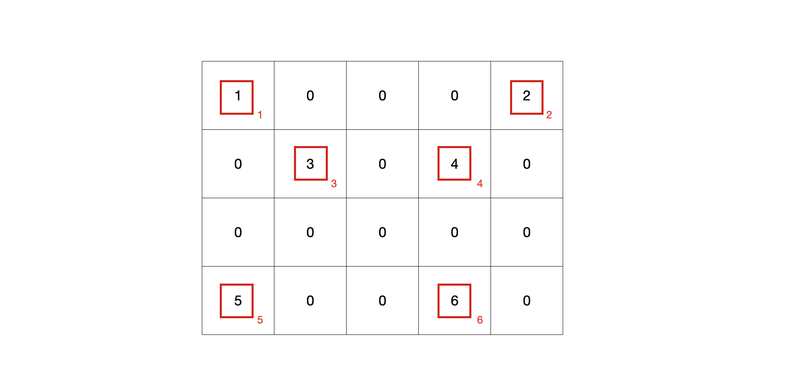

위의 그림처럼 되어있습니다.

In [35]:
from scipy.sparse import csr_matrix

num_user = ratings_title['user_id'].nunique()
num_movie = ratings_title['title'].nunique()

csr_data = csr_matrix((ratings_title['count'].values, (ratings_title['user_id'].values, ratings_title['title'].values)) , shape= (num_user, num_movie))
csr_data

<6040x3548 sparse matrix of type '<class 'numpy.int64'>'
	with 827567 stored elements in Compressed Sparse Row format>

In [36]:
num_user, num_movie

(6040, 3548)

---

## 모델 만들기

### implicit 사용한 모델 제작

In [37]:
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [38]:
from implicit.als import AlternatingLeastSquares
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

---

## 모델 학습 및 결과 확인

### 전치 행렬로 변환

In [39]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3548x6040 sparse matrix of type '<class 'numpy.int64'>'
	with 827567 stored elements in Compressed Sparse Column format>

---

### 모델 학습

In [40]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

---

### 학습 결과 확인

- jumanji라는 영화 이름을 넣고 결과를 확인해보겠음

In [41]:
howon, jumanji = user_to_idx['howon'], movie_to_idx['jumanji']
howon_vector, jumanji_vector = als_model.user_factors[howon], als_model.item_factors[jumanji]
howon_vector

array([-0.2919356 , -0.7120582 , -0.07619209,  0.6293319 ,  0.4370481 ,
        0.25117078,  0.28127915,  0.2882286 , -0.16407132, -0.7724664 ,
       -0.1085931 , -0.0378891 ,  0.1303168 , -0.18995544,  0.24616173,
        0.84776574, -0.07800345, -0.9024365 ,  0.5502629 , -0.23722635,
        0.5331194 ,  0.57492214,  0.46622217,  0.47547835, -0.3496314 ,
       -0.6727496 , -0.28601784, -0.21387018,  0.04268099, -0.32095727,
       -0.13940491,  0.40267566, -0.38235918, -0.13732351, -0.6821036 ,
        0.30758545,  0.2826785 , -0.06416842, -0.05659377,  0.02042666,
       -0.33679315, -0.6153958 ,  0.81657046,  0.20249905,  0.00259046,
       -0.4937512 , -0.47040778, -0.27303317,  0.3917727 , -0.01087935,
        0.2682669 ,  0.8332576 , -0.41928676,  0.14652865, -0.14748915,
       -0.20646107,  0.04573577,  0.7009812 ,  0.13116793,  0.76072925,
       -0.654083  ,  0.2601319 ,  0.61831474, -0.18700774, -0.13096455,
       -0.47787464, -0.4478188 , -0.25822142,  0.4240451 , -0.56

In [42]:
jumanji_vector

array([ 0.00323552,  0.01107751,  0.02145449,  0.01447873,  0.01348083,
       -0.01250626,  0.00162948, -0.0088886 , -0.01609576, -0.01711615,
        0.00976511, -0.02263722,  0.01490459, -0.01162901,  0.00719597,
        0.00407539,  0.00753915, -0.00937729,  0.00550155,  0.03319505,
        0.01550916,  0.00449279,  0.02946272,  0.02307026, -0.00573784,
       -0.00358038, -0.00281357,  0.00289238,  0.01083498, -0.01192366,
       -0.00823692,  0.0241908 , -0.00028429, -0.0118984 , -0.0122841 ,
       -0.00827361,  0.02208996,  0.01380047,  0.01391849, -0.00191448,
       -0.00910758,  0.01416548,  0.01639487,  0.00272667,  0.02390603,
       -0.01490853, -0.01290504,  0.00012299,  0.00590496,  0.02727851,
        0.00072864,  0.02955882, -0.00471503,  0.00113028, -0.00425553,
        0.00158297,  0.00462007,  0.0166722 ,  0.01689152,  0.00868521,
        0.008161  ,  0.01827838,  0.03074193, -0.01980624,  0.00856652,
        0.03556683, -0.00406757, -0.00359263,  0.00356494,  0.00

---

### 벡터 결과를 내적하여 확률값 계산

나온 벡터 결과들을 dot 함수를 사용하여 내적하면 확률값을 구할수가 있습니다.

저는 30퍼 정도가 나왔네요.....

이 영화를 보면 후회하겠네요

In [43]:
np.dot(howon_vector, jumanji_vector)

0.30004254

이번껀 3퍼가 나왔네요 ㅎㅎㅎㅎㅎ

In [44]:
saving = movie_to_idx['platoon']
saving_vector = als_model.item_factors[saving]
np.dot(howon_vector, saving_vector)

0.03678559

---

### 비슷한 영화 추천해주기

이번에는 영화를 하나 입력해보고 그거와 유사한 영화를 확인해보겠습니다.

platoon라는 영화로 확인을 해봤습니다.

In [45]:
favorite_movie = 'platoon'
movie_id = movie_to_idx[favorite_movie]
similar_movie = als_model.similar_items(movie_id, N=15)
similar_movie

[(1010, 0.99999976),
 (1344, 0.58392113),
 (1062, 0.5812317),
 (951, 0.5743194),
 (771, 0.54492277),
 (1276, 0.51999396),
 (716, 0.49887365),
 (1778, 0.48498788),
 (1340, 0.47896957),
 (1159, 0.4631568),
 (971, 0.45345223),
 (3013, 0.44665155),
 (1774, 0.43511054),
 (1155, 0.40621018),
 (1385, 0.3860764)]

역시나 튜플 형식으로 나오는군요

제목이 보이게 바꾸어줍시다.

바꾸면서 추천 점수까지 같이 보여지도록 해보겠습니다.

In [46]:
idx_to_movie = {v:k for k,v in movie_to_idx.items()}
for i, j in similar_movie:
    print(idx_to_movie[i], ":", j)

platoon : 0.99999976
killing fields, the : 0.58392113
full metal jacket : 0.5812317
last emperor, the : 0.5743194
deer hunter, the : 0.54492277
apocalypse now : 0.51999396
good morning, vietnam : 0.49887365
pink floyd - the wall : 0.48498788
patton : 0.47896957
red dawn : 0.4631568
glory : 0.45345223
open season : 0.44665155
raging bull : 0.43511054
hoosiers : 0.40621018
right stuff, the : 0.3860764


In [47]:
def get_similar_artist(movie_name: str):
    movie_id = movie_to_idx[movie_name]
    similar_movie = als_model.similar_items(movie_id)
    similar_movie = [idx_to_movie[i[0]] for i in similar_movie]
    return similar_movie

---

### 사용자에게 영화 추천

이번에는 사용자에게 직접 영화를 추천해보겠습니다.

20개 정도 추천을 해보도록 하겠습니다.

In [48]:
user = user_to_idx['howon']
movie_recommend = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
movie_recommend

[(4, 0.32425487),
 (320, 0.2981775),
 (539, 0.27795815),
 (1023, 0.24313694),
 (59, 0.21882033),
 (589, 0.21463028),
 (455, 0.21158618),
 (502, 0.20686856),
 (38, 0.20403814),
 (1671, 0.17985871),
 (33, 0.17965671),
 (172, 0.17347509),
 (328, 0.17244488),
 (432, 0.17062),
 (118, 0.16630149),
 (615, 0.16180989),
 (1107, 0.15965937),
 (1068, 0.15956517),
 (1940, 0.1573891),
 (125, 0.15121423)]

In [49]:
for i, k in movie_recommend:
    print(movies[movies['movie_id']==i]['title'].values[0],' :',k)

waiting to exhale  : 0.32425487
suture  : 0.2981775
sleepless in seattle  : 0.27795815
winnie the pooh and the blustery day  : 0.24313694
confessional, the (le confessionnal  : 0.21882033
terminator 2: judgment day  : 0.21463028
free willy  : 0.21158618
next karate kid, the  : 0.20686856
it takes two  : 0.20403814
deceiver  : 0.17985871
wings of courage  : 0.17965671
johnny mnemonic  : 0.17347509
tales from the crypt presents: demon knight  : 0.17244488
city slickers ii: the legend of curly's gold  : 0.17062
if lucy fell  : 0.16630149
bread and chocolate (pane e cioccolata  : 0.16180989
loser  : 0.15965937
crossfire  : 0.15956517
gentleman's agreement  : 0.1573891
flirting with disaster  : 0.15121423


---

### 데이터 프레임으로 결과 시각화

데이터 프레임 형식으로 결과를 출력해보겠습니다.

In [50]:
movies[movies['movie_id'].isin([i[0] for i in movie_recommend])][['title','genre']]

,title,genre
3,waiting to exhale,Comedy|Drama
32,wings of courage,Adventure|Romance
37,it takes two,Comedy
58,"confessional, the (le confessionnal",Drama|Mystery
116,if lucy fell,Comedy|Romance
123,flirting with disaster,Comedy
170,johnny mnemonic,Action|Sci-Fi|Thriller
317,suture,Film-Noir|Thriller
324,tales from the crypt presents: demon knight,Horror
428,city slickers ii: the legend of curly's gold,Comedy|Western


---

### 영화 기여도 확인

In [75]:
# 추천 목록에 있는 suture로 확인해보았다.
# suture 추천에 대하여, 먼저 설정했던 5개의 기여도를 확인
# toy story가 가장 높은 기여도를 보여준다.

best_movie = movie_to_idx['suture']
explain = als_model.explain(user, csr_data, itemid=best_movie)
[(idx_to_movie[i[0]], i[1]) for i in explain[1]]

[('toy story', 0.003479206007435468),
 ('waiting to exhale', 0.0018963329892242595),
 ('grumpier old men', -0.0024828011832982774),
 ('father of the bride part ii', -0.002774970959466793),
 ('jumanji', -0.006942128975437126)]

---

## 피어슨 상관계수를 사용한 간단한 추천시스템

### 데이터 전처리

이번에는 피어슨 상관계수를 이용하여 추천 시스템을 만들어보겠습니다.

먼저 데이터 전처리를 하겠습니다.

In [51]:
rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
# 사용할 컬럼
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python')
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [52]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
meta = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
meta.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


---

### 데이터 전처리(1)

확인하기 편하게 데이터를 합쳐줍니다.

In [53]:
data = pd.merge(ratings, meta, on='movie_id', how='inner')
data.head()

,user_id,movie_id,rating,timestamp,title,genre
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama


In [54]:
data.drop('timestamp', axis = 1, inplace = True)

---

### 데이터 전처리(2)

이번에는 피벗테이블로 만들어 보겠습니다.

피벗테이블은 두개의 열을 행 인덱스와, 열 인덱스로 사용하여 데이터를 펼쳐놓은것을 뜻합니다.

즉, 행은 유저 아이디가 되고 열은 영화이름 데이터에는 영화 점수가 들어가게 됩니다.

NaN이라고 되어있는건 결측치가 아닙니다.

그 영화에 대한 평가가 없을뿐입니다.

In [55]:
matrix = data.pivot_table(index='user_id', columns='title', values='rating')
matrix.head()

title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---

### 피어슨 상관계수 공식을 사용한 함수 만들기


피어슨 상관계수를 사용하여 영화간에 상관관계를 파악하여 

가장 유사한 영화를 추천해주는 추천 시스템을 개발해보겠습니다.

피어슨 상관계수 공식과 관련 링크 첨부합니다.

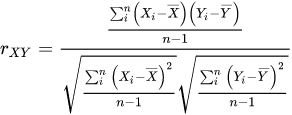

링크 : https://ko.wikipedia.org/wiki/%ED%94%BC%EC%96%B4%EC%8A%A8_%EC%83%81%EA%B4%80_%EA%B3%84%EC%88%98

In [76]:
#가중치 설정
GENRE_WEIGHT = 0.1

#피어슨 상관계수 공식을 함수로 만듬
def pearsonR(s1, s2):
    s1_c = s1 - s1.mean()
    s2_c = s2 - s2.mean()
    return np.sum(s1_c * s2_c) / np.sqrt(np.sum(s1_c ** 2) * np.sum(s2_c ** 2))

#추천 시스템을 함수로 구현
def recommend(input_movie, matrix, n, similar_genre=True):
    input_genres = meta[meta['title'] == input_movie]['genre']
    result = []
    for title in matrix.columns:
        
        #현재 상관계수를 구할라는 영화과 검색한 영화와 같으면 패스
        if title == input_movie:
            continue
            
        #다를 경우 상관관계를 계산함
        cor = pearsonR(matrix[input_movie], matrix[title])
        if similar_genre and len(input_genres) > 0:
            temp_genres = meta[meta['title'] == title]['genre']
            same_count = np.sum(np.isin(input_genres, temp_genres))
            #가중치 업데이트
            cor += (GENRE_WEIGHT * same_count)
        if np.isnan(cor):
            continue
        else:
            #상관관계 값을 result라는 리스트에 담아둠
            result.append((title, '{:.2f}'.format(cor), temp_genres))
            
    result.sort(key=lambda r: r[1], reverse=True)
    return result[:n]

---

### 결과 확인

저는 1-900 (1994)라는 영화를 기준으로 비슷한 장르의 영화를 10개 뽑아봤습니다.

주의 : movie 데이터에 포함되어있는 영화만 검색이 가능합니다. 꼭 풀네임으로 입력해주세용

In [57]:
recommend_result = recommend('1-900 (1994)', matrix, 10, similar_genre=True)

pd.DataFrame(recommend_result, columns = ['Title', 'Correlation', 'Genre'])

,Title,Correlation,Genre
0,Little Boy Blue (1997),0.40,"1821 Drama Name: genre, dtype: object"
1,Heidi Fleiss: Hollywood Madam (1995),0.26,"97 Documentary Name: genre, dtype: object"
2,Peeping Tom (1960),0.22,"2419 Drama|Horror|Thriller Name: genre, dty..."
3,"Affair to Remember, An (1957)",0.15,"920 Romance Name: genre, dtype: object"
4,Against All Odds (1984),0.15,"3137 Romance Name: genre, dtype: object"
5,Above the Rim (1994),0.11,"405 Drama Name: genre, dtype: object"
6,"Masque of the Red Death, The (1964)",0.11,"2715 Horror Name: genre, dtype: object"
7,"Autumn Tale, An (Conte d'automne) (1998)",0.10,"2639 Romance Name: genre, dtype: object"
8,"Chambermaid on the Titanic, The (1998)",0.10,"2088 Romance Name: genre, dtype: object"
9,City of Angels (1998),0.10,"1767 Romance Name: genre, dtype: object"


---

## 마무리

### - 어려웠던 점.

코랩에서는 코드가 제대로 작동하지 않았습니다.

전치행렬 문제가 아니라 추천영화를 두가지 리스트로 분리해서 불러왔습니다.

오류를 끝까지 해결하고 싶어 도전했지만, 결국 패배하고 쥬피터 노트북으로 작성하였습니다....

### - 미숙한 점.

데이터 전처리가 미숙하다고 생각합니다.

교육 시작한지 몇달이 지났지만 데이터 전처리는 아직도 미숙합니다...

꾸준히 공부하는게 답인거 같습니다.

### - 알아낸 점.

추천 시스템에 종류가 상당히 다양하다는 것을 알아냈습니다.

상황에 따라서 쓰는것도 다르고 혹은 굳이 모델을 만들지 않고도 만들 수 있습니다.

### - 회고

더 다양한 구현 기법을 찾아보고 실제로 구현해보아야 된다고 생각합니다.

피어슨 상관계수를 사용한 추천 시스템이 데이터 전처리나 성능 면에서 더 뛰어난거 같습니다.

물론 학습 횟수를 늘리면 결과가 달라질수도 있습니다.

그렇지만 구현 시간적인 측면에서는 피어슨이 압도적입니다.

추후 과제로는 간단하면서 성능이 좋은 모델을 만들고 싶습니다.